## eVIP Analysis
This notebook runs the expression-based variant-impact phenotyping (eVIP) method ([Berger et al., 2016](https://pubmed.ncbi.nlm.nih.gov/27478040/))

In [1]:
import json
import os
import sys

import pandas as pd
import numpy as np

from plotly import graph_objects as go
from plotly.subplots import make_subplots
from plotly import express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Set to "svg" or "png" for non-interactive plots

import correlations as corr
import mvip

# Load expression data

In [2]:
expression = pd.read_parquet('l1000.parquet')

## Ignore `TP53` gene

In [3]:
expression = expression[~expression.x_mutation_status.str.contains('TP53')].copy()
expression.info()
corr_matrix = np.asarray(expression[expression.index])
expression = expression[expression.columns[0:53]]
expression["original_index"] = expression.index
expression.index = range(len(expression))
print(expression.shape, corr_matrix.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 3536 entries, TA.OE014_A549_96H_X1_B19:A03 to TA.OE015_A549_96H_X8_B19:P22
Columns: 4285 entries, bead_batch to TA.OE015_A549_96H_X8_B19:B11
dtypes: float32(4232), float64(4), int64(15), object(34)
memory usage: 58.5+ MB
(3536, 54) (3536, 3536)


# eVIP analysis with a single variant
## Identify allele of interest and controls

In [4]:
allele_mask = expression["x_mutation_status"] == "ARAF_p.D429A"
wild_type_mask = expression["x_mutation_status"] == "ARAF_WT.c"
controls_mask = expression["pert_iname"] == "EMPTY"
allele_index = expression[allele_mask].index
wild_type_index = expression[wild_type_mask].index

## Get correlation matrices

In [5]:
control_wild_type_matrix = corr.allele_to_control_matrix(wild_type_index, expression, "mfc_plate_name", controls_mask, 8, corr_matrix)
wild_type_corr_matrix = corr.sample_rectangular_matrix(wild_type_index, wild_type_index, corr_matrix)
cross_corr_matrix = corr.sample_rectangular_matrix(wild_type_index, allele_index, corr_matrix)
allele_corr_matrix = corr.sample_rectangular_matrix(allele_index, allele_index, corr_matrix)
control_allele_matrix = corr.allele_to_control_matrix(allele_index, expression, "mfc_plate_name", controls_mask, 8, corr_matrix)

matrices = [control_wild_type_matrix, wild_type_corr_matrix, cross_corr_matrix, allele_corr_matrix, control_allele_matrix]
samples = ["WT_CTL", "WT_WT", "MUT_WT","MUT_MUT", "MUT_CTL"]

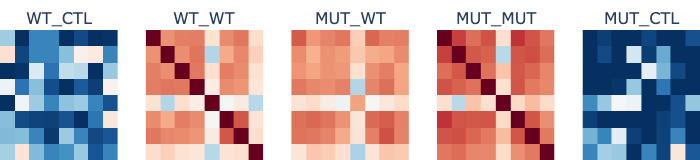

In [6]:
fig = make_subplots(rows=1, cols=5, subplot_titles=samples)
zranges = {'zmin': -0.2,
           'zmax': 1.0}

for i, matrix in enumerate(matrices, 1):
    hmap = go.Heatmap(z=matrix, colorscale='RdBu_r', **zranges)
    fig.add_trace(hmap, row=1, col=i)
fig.update_traces(showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False, autorange='reversed')
fig.update_layout(height=160, margin=dict(l=0, r=0, t=30, b=0))

In [7]:
row = np.median(cross_corr_matrix, axis=0)
col = np.median(cross_corr_matrix, axis=1)
cross_corr_median = np.concatenate([row, col])
dots = pd.DataFrame()
dots = dots.append( [{"Sample":"WT_CTL","Correlation":k} for k in np.median(control_wild_type_matrix, axis=1)] )
dots = dots.append( [{"Sample":"WT_WT","Correlation":k} for k in corr.correlation_median_row(wild_type_corr_matrix)] )
dots = dots.append( [{"Sample":"MUT_WT","Correlation":k} for k in cross_corr_median] )
dots = dots.append( [{"Sample":"MUT_MUT","Correlation":k} for k in corr.correlation_median_row(allele_corr_matrix)] )
dots = dots.append( [{"Sample":"MUT_CTL","Correlation":k} for k in np.median(control_allele_matrix, axis=1)] )

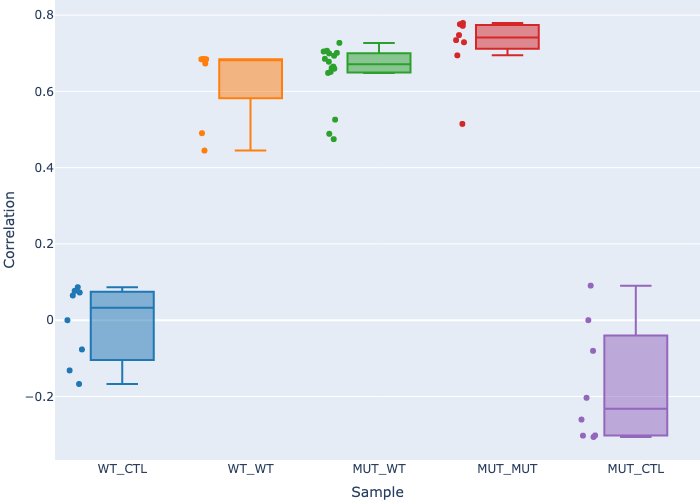

In [8]:
PYPLT_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                '#bcbd22', '#17becf']
fig = px.box(dots, x='Sample', y='Correlation', color='Sample',
             points='all', color_discrete_sequence=PYPLT_COLORS)
fig.update_layout(showlegend=False,
                  margin=dict(l=0, r=0, t=0, b=0)
                 )

## Wilconxon test
The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of differences x-y is symmetric about zero. It is a non-parametric version of the paired T-test

In [9]:
print("H0:", mvip.H0)
pvalue = mvip.wilcoxon_test(allele_corr_matrix, control_allele_matrix)
print("pvalue", pvalue)
if pvalue < 0.05: print("Reject H_0")
else: print("Accept H_0")

H0: There is no difference between replicate self correlation and control correlation
pvalue 0.0078125
Reject H_0


## Kruskal-Wallis test

In [10]:
# Using all values of the matrices to compute the distributions
self_corr_upper = corr.sample_upper_triangle(allele_index, corr_matrix)
print("H_0: ", mvip.H0)
pvalue = mvip.kruskal_wallis_test(self_corr_upper, control_allele_matrix)
print("pvalue",pvalue)
if pvalue < 0.05: print("Reject H_0")
else: print("Accept H_0")

H_0:  There is no difference between replicate self correlation and control correlation
pvalue 4.272010878320125e-14
Reject H_0


In [11]:
# Using the median rows of the matrices to represent the distributions
self_corr_upper = corr.sample_upper_triangle(allele_index, corr_matrix)
print("H_0: ", mvip.H0)
pvalue = mvip.kruskal_wallis_on_medians(allele_corr_matrix, control_allele_matrix)
print("pvalue", pvalue)
if pvalue < 0.05: print("Reject H_0")
else: print("Accept H_0")

H_0:  There is no difference between replicate self correlation and control correlation
pvalue 0.000777530446940383
Reject H_0


# eVIP analysis for all variants

In [12]:
# Read treatments originally studied in the paper 
treatments = pd.read_csv("inputs/metadata/l1k/treatments.csv")
expression["index"] = expression.index
# Filter expression frame to keep only these records (preserving index)
exprs = pd.merge(treatments, expression, how="inner", left_on="pert_iname", right_on="pert_iname")
print(len(exprs), corr_matrix.shape, "Alleles:", len(exprs["x_mutation_status"].unique()))
# Extract the mutant alleles in the frame
alleles = exprs["x_mutation_status"].unique()
alleles = [a for a in alleles if a.find("WT") == -1]
print("Number of mutants:",len(alleles))

2416 (3536, 3536) Alleles: 302
Number of mutants: 176


In [13]:
expression["matrix_index"] = expression.index
treated_samples = expression[expression.pert_type.str.find("ctl") == -1]
null_treatments = corr.null_distribution(treated_samples["matrix_index"], corr_matrix, 8, repeats=1000)
null_treatments = [c for c in null_treatments if c != 0]
null_treatments = null_treatments[0:1000]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.16it/s]


In [14]:
images_dir = 'outputs/images/expression/'
os.makedirs(images_dir, exist_ok=True)
mvip_test = mvip.Morphology_VIP_CNN_Features(expression, 
                                corr_matrix, 
                                treatment_samples=8, 
                                control_samples=20, 
                                controls_value="EMPTY", 
                                perturbation_field="x_mutation_status",
                                controls_field="pert_iname",
                                plate_field="mfc_plate_name"
                        )
results = mvip_test.test_allele_set(alleles, create_images=True, null_distribution=null_treatments,
                                    images_dir=images_dir)
results = mvip_test.adjust_pvalues(results)
results.to_csv("outputs/benchmark_results_expression.csv", index=False)
results

No wild type for: AKT1_p.D323Y
No wild type for: PTEN_p.H123Y
No wild type for: PTEN_p.M35I
No wild type for: SMAD4_p.D493N
No wild type for: SMAD4_p.G386V
No wild type for: SMAD4_p.P215S
No wild type for: SMAD4_p.P356R
No wild type for: SMAD4_p.R361H
No wild type for: SMAD4_p.V492F
No wild type for: TERT_p.L593F
No wild type for: BFP
No wild type for: HCRED
No wild type for: LUCIFERASE
No wild type for: EGFP
No wild type for: UnTrt


,wild_type,wt_samples,mutant,mut_samples,impact_test,strength_test,directionality_test,power_test,is_sig_impact_test,adjusted_impact_test,is_sig_strength_test,adjusted_strength_test,is_sig_power_test,adjusted_power_test,prediction
0,ABCB9_WT.c,8.0,ABCB9_p.R281L,8.0,0.042839,0.400814,1.0,6.333670e-03,False,0.058950,False,0.481575,True,8.223555e-03,NT
1,AKR1B1_WT.c,8.0,AKR1B1_p.F252L,8.0,0.065602,0.752714,1.0,7.325290e-12,False,0.084495,False,0.781851,True,4.105677e-11,NT
2,ARAF_WT.c,8.0,ARAF_p.D429A,8.0,0.007355,0.006323,1.0,6.417767e-12,True,0.011497,True,0.014971,True,4.105677e-11,GOF
3,ARAF_WT.c,8.0,ARAF_p.S214C,8.0,0.000005,0.045999,0.0,1.941913e-11,True,0.000071,False,0.077145,True,7.356961e-11,COF
4,ARAF_WT.c,8.0,ARAF_p.S214F,8.0,0.000005,0.035692,0.0,1.221305e-09,True,0.000071,False,0.063147,True,3.121113e-09,COF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,ZBTB24_WT.c,8.0,ZBTB24_p.M78I,8.0,0.116579,1.000000,0.0,1.562591e-03,False,0.140069,False,1.000000,True,2.132009e-03,NT
157,ZBTB24_WT.c,8.0,ZBTB24_p.Q669R,8.0,0.007692,0.092892,1.0,5.956186e-01,True,0.011908,False,0.135960,False,6.107936e-01,COF
158,ZNF597_WT.c,8.0,ZNF597_p.L283V,8.0,0.001684,0.001629,0.0,6.417767e-12,True,0.003013,True,0.004684,True,4.105677e-11,LOF
159,ZNF597_WT.c,8.0,ZNF597_p.R247T,8.0,0.000002,0.000778,0.0,7.023679e-12,True,0.000057,True,0.002721,True,4.105677e-11,LOF


## Save phenotype replicability

In [15]:
signal_strength = {}
treatments = expression["x_mutation_status"].unique()
for trt in treatments:
    index = expression["x_mutation_status"] == trt
    median = corr.median_correlation(expression[index].index, corr_matrix)
    signal_strength[trt] = float(median)

with open('outputs/signal_strength_l1k.json', 'w') as fp:
    json.dump(signal_strength, fp)